
# Human Face Detection (OpenCV, Python) — Colab Notebook

- Choose **Haar** or **DNN** (face-only) detector.
- Upload dataset as **ZIP/TGZ/TAR**. Results are saved to `outputs/` and optional face crops to `crops/`.


In [1]:

#@title Install dependencies
!pip -q install opencv-python imutils matplotlib


In [2]:

#@title Imports & helpers
import os, glob, zipfile, tarfile, random, shutil
import numpy as np
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def show(img, title=None):
    if title: print(title)
    cv2_imshow(img)

def ensure_dir(p): os.makedirs(p, exist_ok=True)
def relpath_from(root, full): return os.path.relpath(full, root)
print("OpenCV:", cv2.__version__)


OpenCV: 4.12.0


In [3]:

#@title Download DNN face model (skip if using Haar)
!wget -q -O deploy.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q -O res10_300x300_ssd_iter_140000_fp16.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/master/res10_300x300_ssd_iter_140000_fp16.caffemodel
print("DNN face model ready.")


DNN face model ready.


In [4]:

#@title Choose detector & parameters
DETECTOR = "haar"  #@param ["haar", "dnn"]

# Haar params
scaleFactor = 1.1  #@param {type:"number"}
minNeighbors = 5   #@param {type:"integer"}
minSize = (60,60)  #@param

# DNN params
conf_threshold = 0.5  #@param {type:"number"}

haar = None; net = None
if DETECTOR == "haar":
    haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
else:
    net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")
print("Detector:", DETECTOR)


Detector: haar


In [5]:

#@title Upload dataset archive (ZIP/TGZ/TAR)
DATA_ROOT = "data"
!rm -rf {DATA_ROOT} outputs crops && mkdir -p {DATA_ROOT}
print("Upload archive now...")
uploaded = files.upload()
arc = next(iter(uploaded.keys()))
print("Extracting:", arc)

if arc.lower().endswith(".zip"):
    import zipfile
    with zipfile.ZipFile(arc, 'r') as z: z.extractall(DATA_ROOT)
elif arc.lower().endswith((".tgz",".tar.gz",".tar")):
    import tarfile
    with tarfile.open(arc, 'r:*') as t: t.extractall(DATA_ROOT)
else:
    raise ValueError("Please upload ZIP or TGZ/TAR.")

def list_images(root="data"):
    for p,_,fs in os.walk(root):
        for f in fs:
            if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff")):
                yield os.path.join(p,f)

images = list(list_images(DATA_ROOT))
print("Found images:", len(images))
print("Example:", images[:5])


Upload archive now...


Saving lfw-funneled.tgz to lfw-funneled.tgz
Extracting: lfw-funneled.tgz


/tmp/ipython-input-1729046938.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open(arc, 'r:*') as t: t.extractall(DATA_ROOT)


Found images: 13233
Example: ['data/lfw_funneled/Svetislav_Pesic/Svetislav_Pesic_0001.jpg', 'data/lfw_funneled/Larry_Anderson/Larry_Anderson_0001.jpg', 'data/lfw_funneled/Andrea_Kiser/Andrea_Kiser_0001.jpg', 'data/lfw_funneled/Abdul_Rahman/Abdul_Rahman_0001.jpg', 'data/lfw_funneled/Biljana_Plavsic/Biljana_Plavsic_0001.jpg']


In [8]:
#@title Run face detection on dataset
SAVE_CROPS = True  #@param {type:"boolean"}
MAX_IMAGES = 0     #@param {type:"integer"} # 0 = process all

def detect_haar(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = haar.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize)
    return rects

def detect_dnn(img):
    (h,w)=img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img,(300,300)), 1.0, (300,300), (104.0,177.0,123.0))
    net.setInput(blob); det = net.forward()
    rects=[]
    for i in range(det.shape[2]):
        conf = det[0,0,i,2]
        if conf >= conf_threshold:
            box = det[0,0,i,3:7] * np.array([w,h,w,h])
            x1,y1,x2,y2 = box.astype("int")
            x,y,w2,h2 = max(0,x1), max(0,y1), max(0,x2-x1), max(0,y2-y1)
            rects.append((x,y,w2,h2))
    return rects

def detect(img):
    return detect_haar(img) if DETECTOR=="haar" else detect_dnn(img)

ensure_dir("outputs");
if SAVE_CROPS: ensure_dir("crops")

processed=0; with_faces=0; faces_counts=[]

for path in images:
    if MAX_IMAGES and processed>=MAX_IMAGES: break
    img = cv2.imread(path)
    if img is None: continue
    rects = detect(img)
    faces_counts.append(len(rects))
    if len(rects) > 0: with_faces += 1

    vis = img.copy()
    for j,(x,y,w2,h2) in enumerate(rects):
        cv2.rectangle(vis,(x,y),(x+w2,y+h2),(0,255,255),2)
        if SAVE_CROPS:
            crop = img[y:y+h2,x:x+w2]
            out_crop_dir = os.path.join("crops", os.path.dirname(relpath_from(DATA_ROOT, path)))
            os.makedirs(out_crop_dir, exist_ok=True)
            base = os.path.splitext(os.path.basename(path))[0]
            cv2.imwrite(os.path.join(out_crop_dir, f"{base}_face{j}.jpg"), crop)

    out_dir = os.path.join("outputs", os.path.dirname(relpath_from(DATA_ROOT, path)))
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, os.path.basename(path))
    cv2.imwrite(out_path, vis)

    processed += 1

print("Processed:", processed)
print("Images with ≥1 face:", with_faces)
if faces_counts:
    import numpy as np
    print("Avg faces/image:", float(np.mean(faces_counts)))

Processed: 13233
Images with ≥1 face: 13151
Avg faces/image: 1.0418650343837377


Total output files: 13233
outputs/lfw_funneled/Bob_Iger/Bob_Iger_0001.jpg


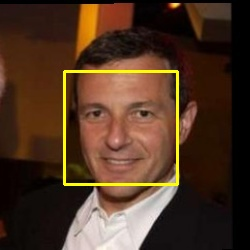

outputs/lfw_funneled/Anders_Ebbeson/Anders_Ebbeson_0002.jpg


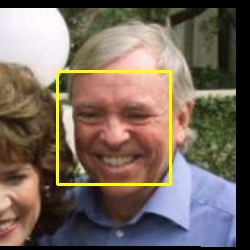

outputs/lfw_funneled/Jean-Marc_de_La_Sabliere/Jean-Marc_de_La_Sabliere_0001.jpg


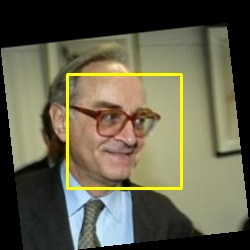

outputs/lfw_funneled/Albert_Costa/Albert_Costa_0005.jpg


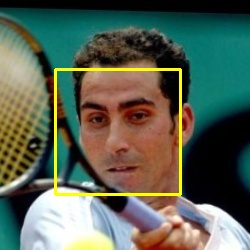

outputs/lfw_funneled/Desiree_McKenzie/Desiree_McKenzie_0001.jpg


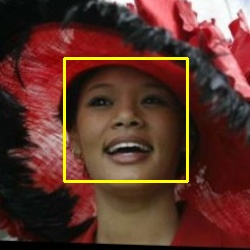

In [9]:

#@title Preview random results
import random, cv2, os
outs=[]
for p,_,fs in os.walk("outputs"):
    for f in fs:
        if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff")):
            outs.append(os.path.join(p,f))

print("Total output files:", len(outs))
for p in random.sample(outs, k=min(5,len(outs))):
    img=cv2.imread(p); show(img, p)


In [10]:

#@title Zip outputs (and crops) for download
import shutil, os
if os.path.exists("face_detection_outputs.zip"): os.remove("face_detection_outputs.zip")
shutil.make_archive("face_detection_outputs", "zip", "outputs")
print("Created: face_detection_outputs.zip")

if os.path.exists("crops"):
    if os.path.exists("face_crops.zip"): os.remove("face_crops.zip")
    shutil.make_archive("face_crops", "zip", "crops")
    print("Created: face_crops.zip")

# Optional direct download:
# from google.colab import files; files.download("face_detection_outputs.zip")
# from google.colab import files; files.download("face_crops.zip")


Created: face_detection_outputs.zip
Created: face_crops.zip
